In [1]:
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
from IS18 import vistools               # display tools
from IS18 import utils                  # IO tools
from IS18 import rectification          # rectification tools
from IS18 import stereo                 # stereo tools
from IS18 import triangulation          # triangulation tools

import srtm4
import s2p
import pickle
import rpcm
from PIL import Image

from bundle_adjust import ba_core
from bundle_adjust import ba_timeseries
from bundle_adjust import ba_utils
from bundle_adjust import ba_offsets

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
%matplotlib inline
np.set_printoptions(linewidth=150)

### Set experiment

In [2]:
ALL_PIPELINE = True
print('Global variables defined')

# select site and order of input pairs
site = 'JAX_161' # IARPA, JAX_113, JAX_161, JAX_251
order = 'heuristic' # oracle, heuristic, sift

exp_name = site+'_ba_offsets_'+order
input_dir = os.path.join('exp/',exp_name)
print('All files will be saved in "'+ input_dir + '"')
os.makedirs(input_dir, exist_ok=True)

Global variables defined
All files will be saved in "exp/JAX_161_ba_offsets_heuristic"


### Load data

Number of images to be used: 26
Finished loading RPC coefficients
Finished cropping the AOI in each image



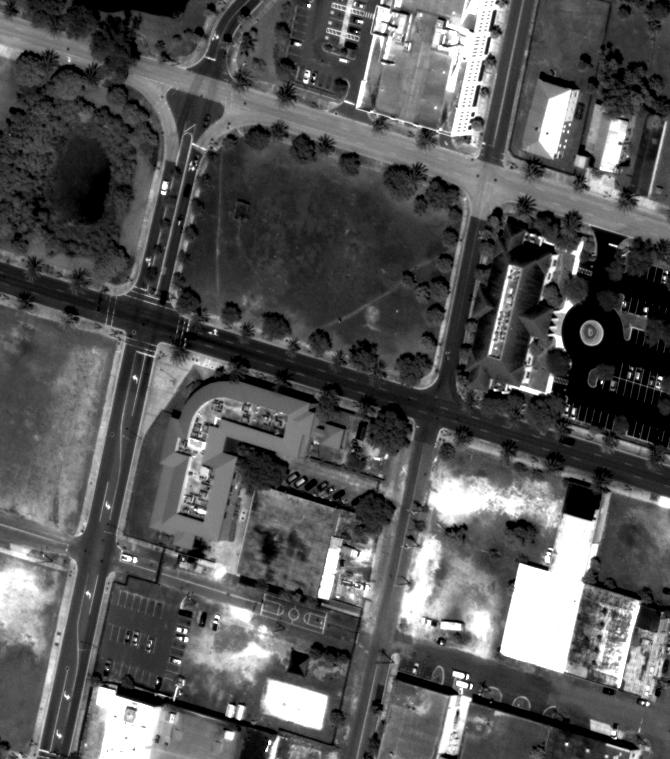
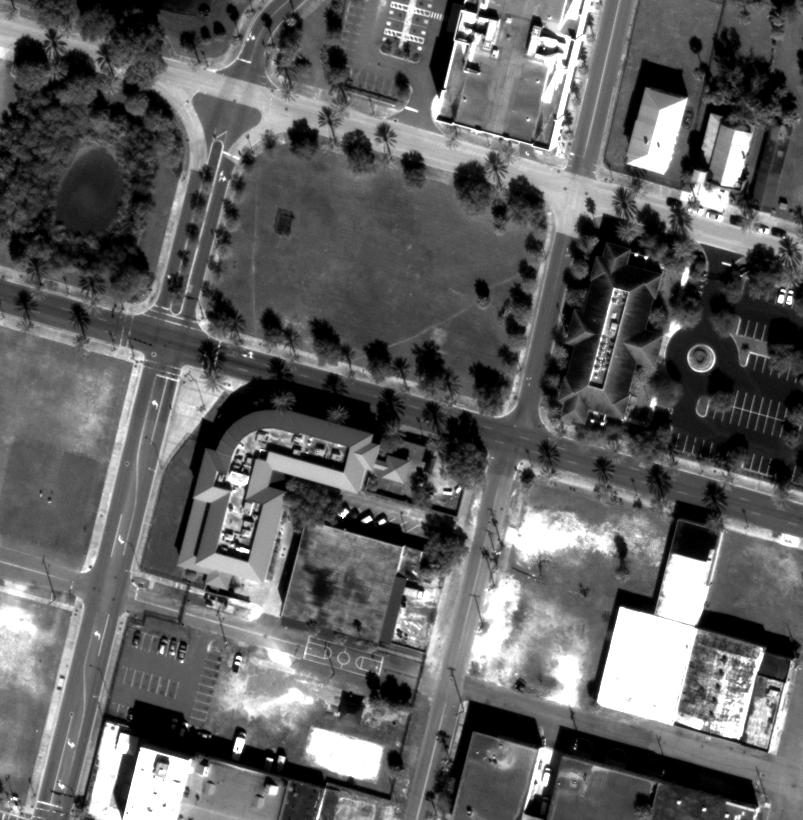
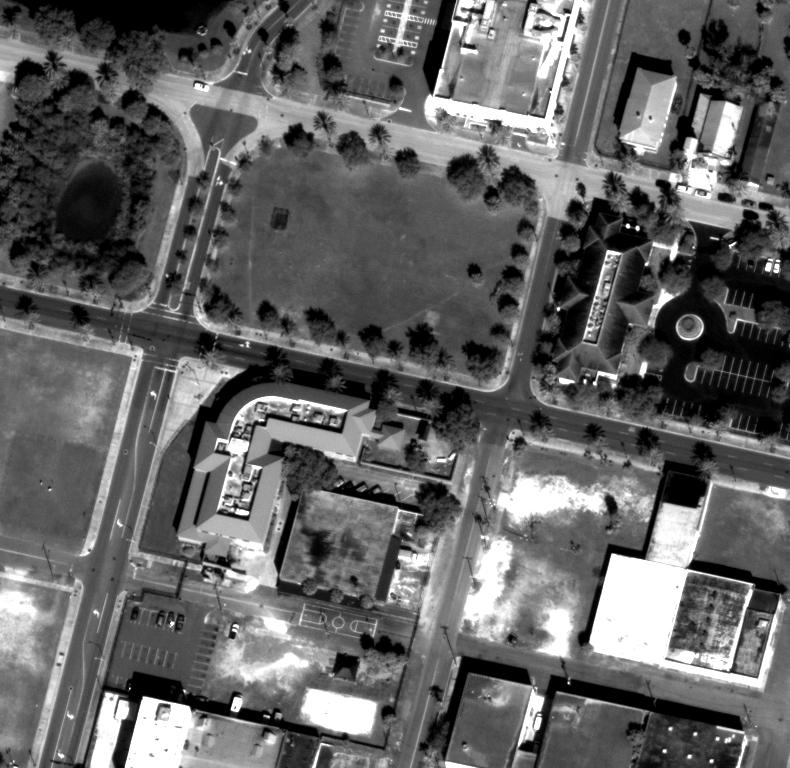
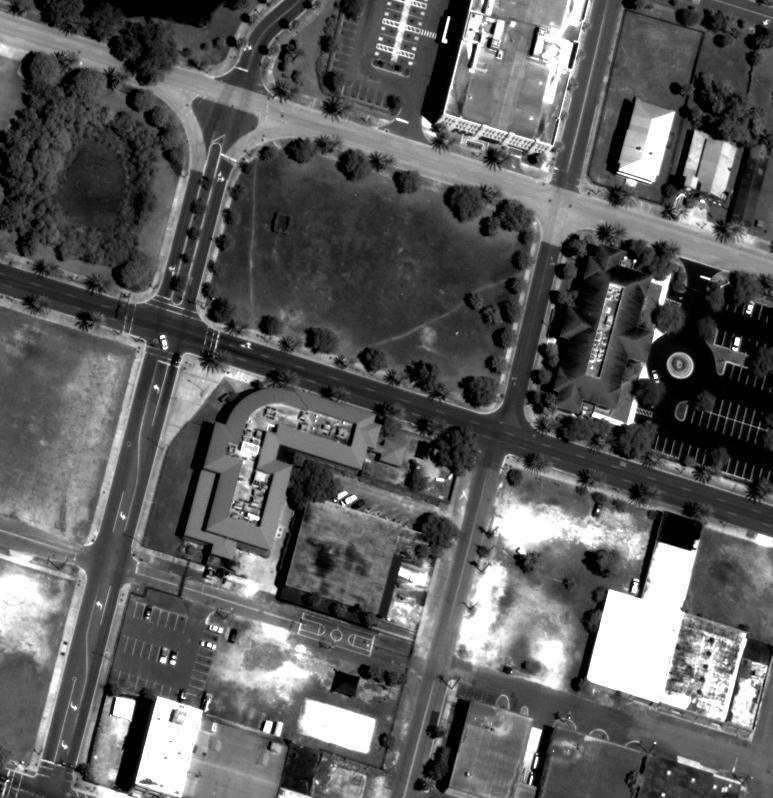
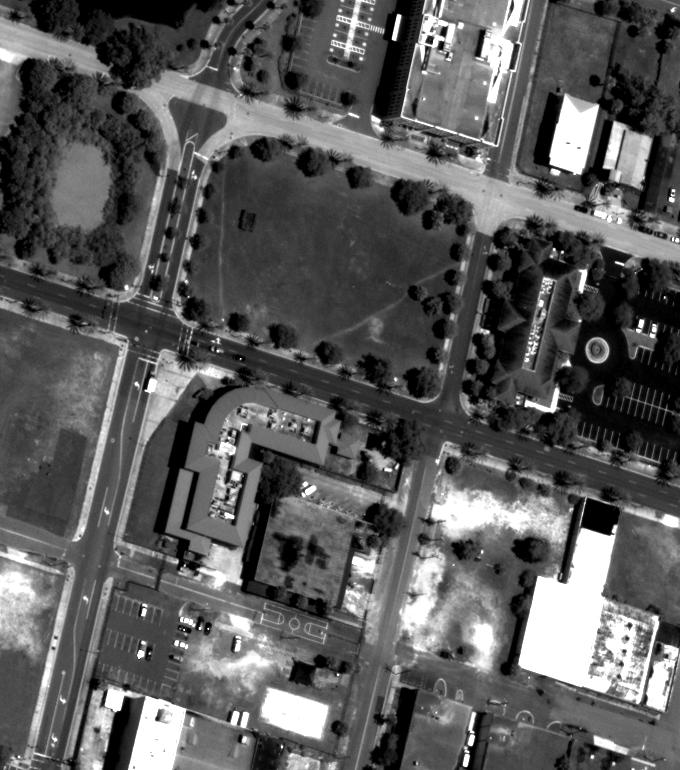
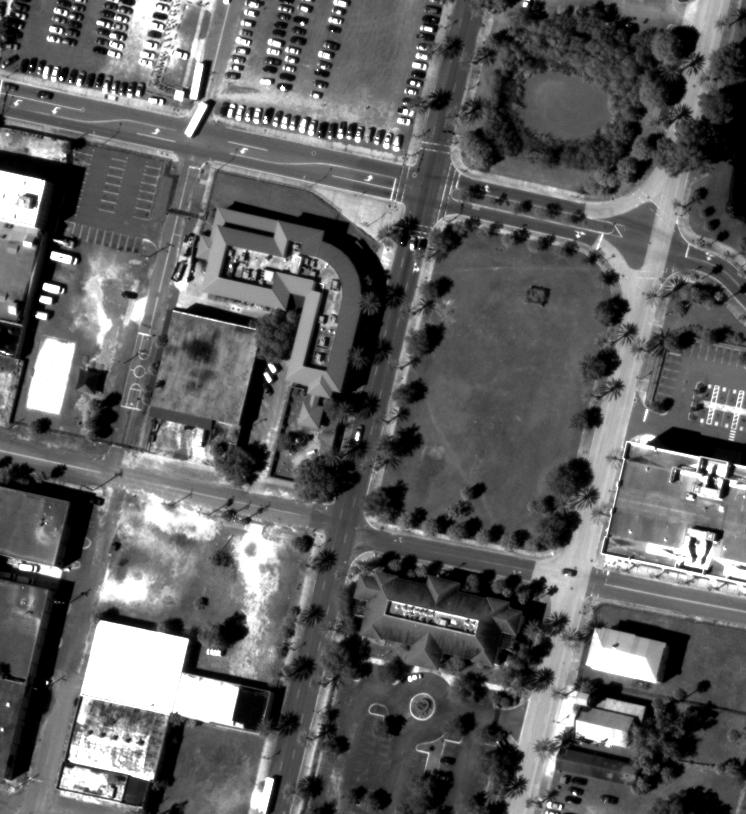
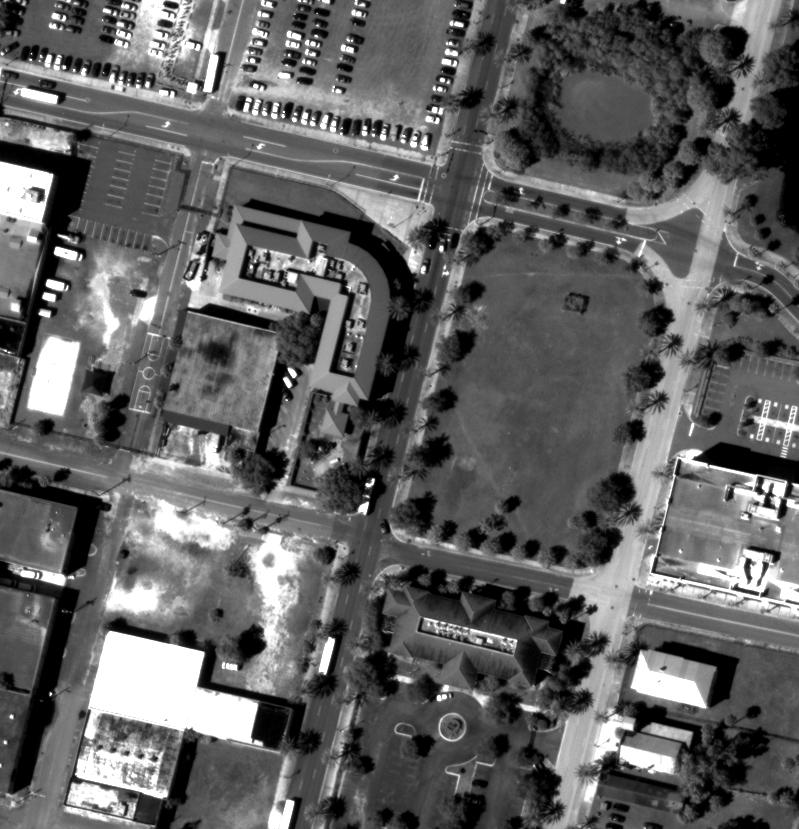
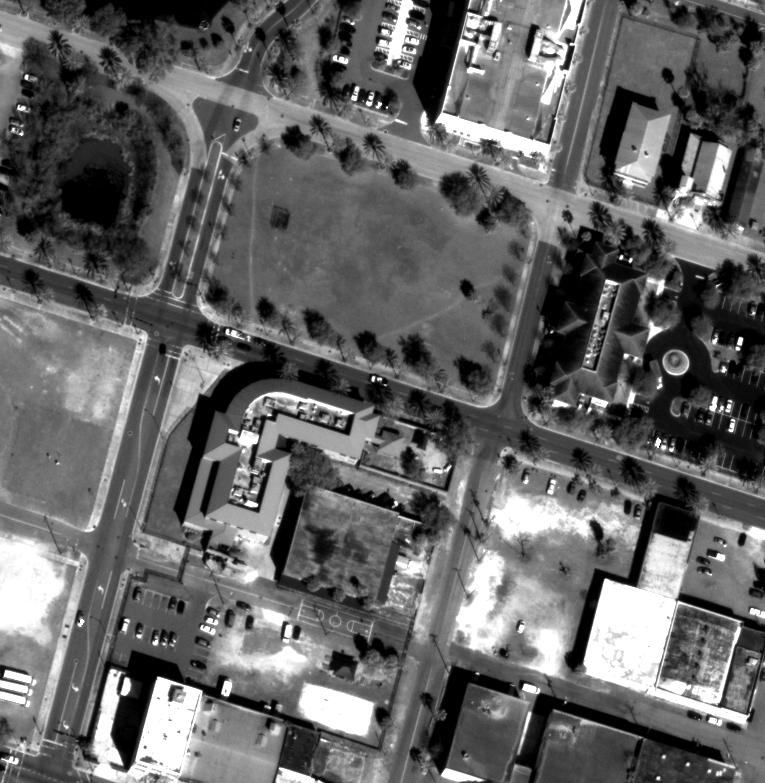
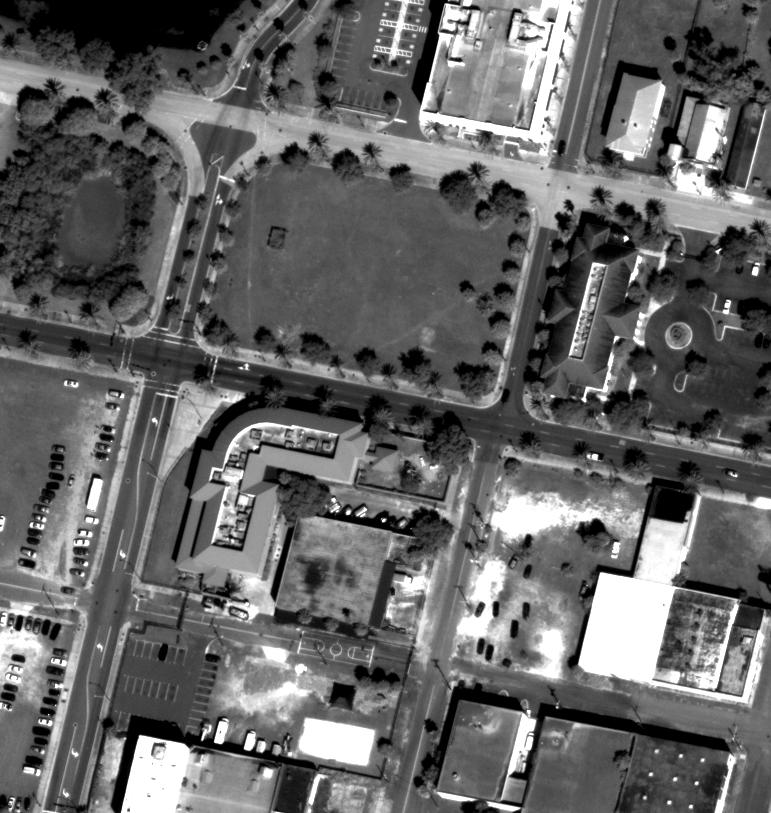
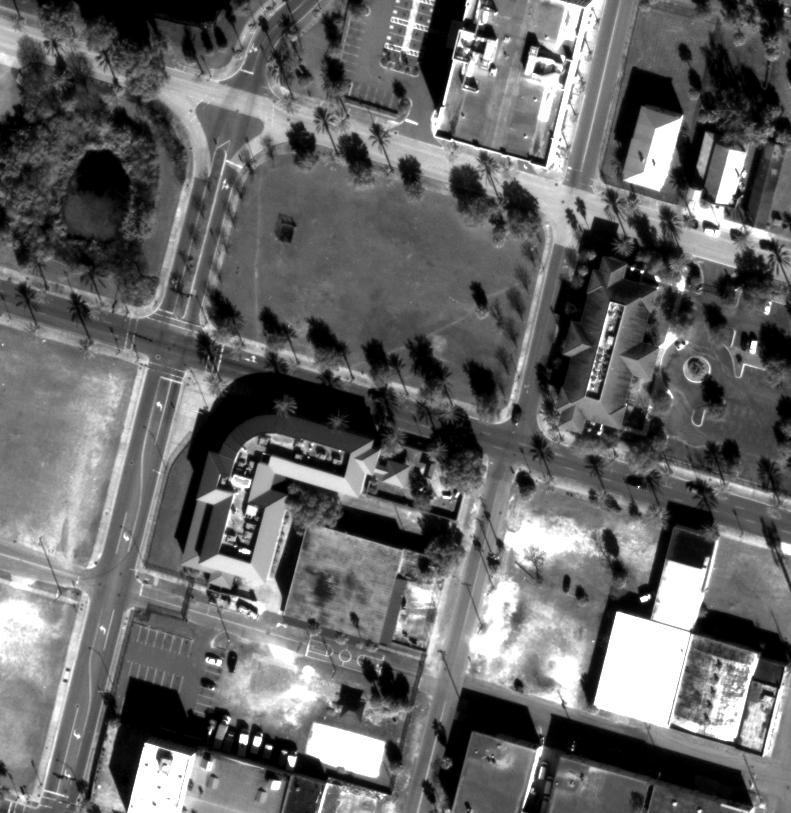
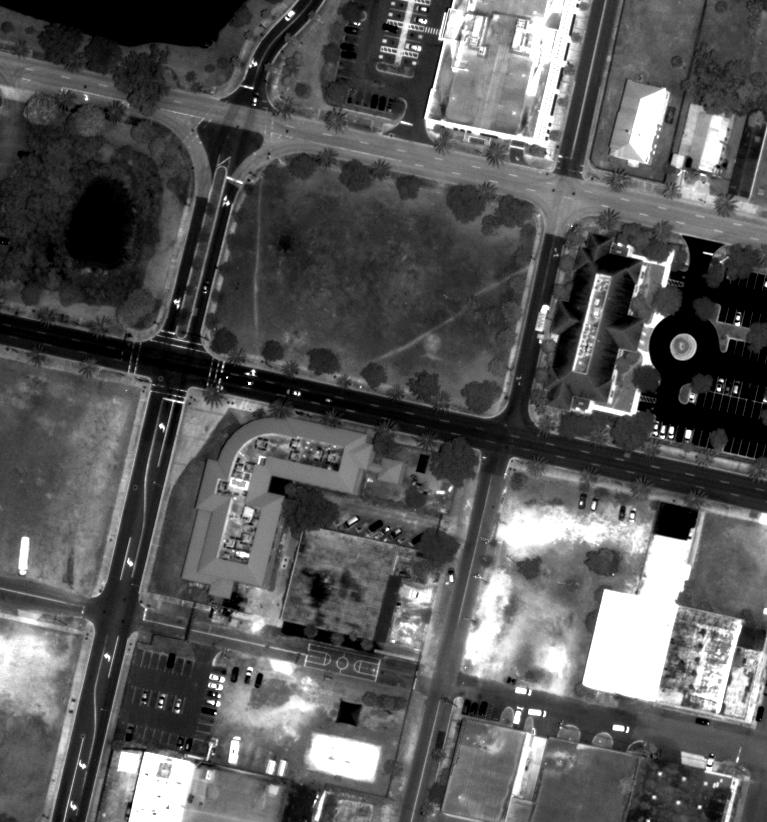
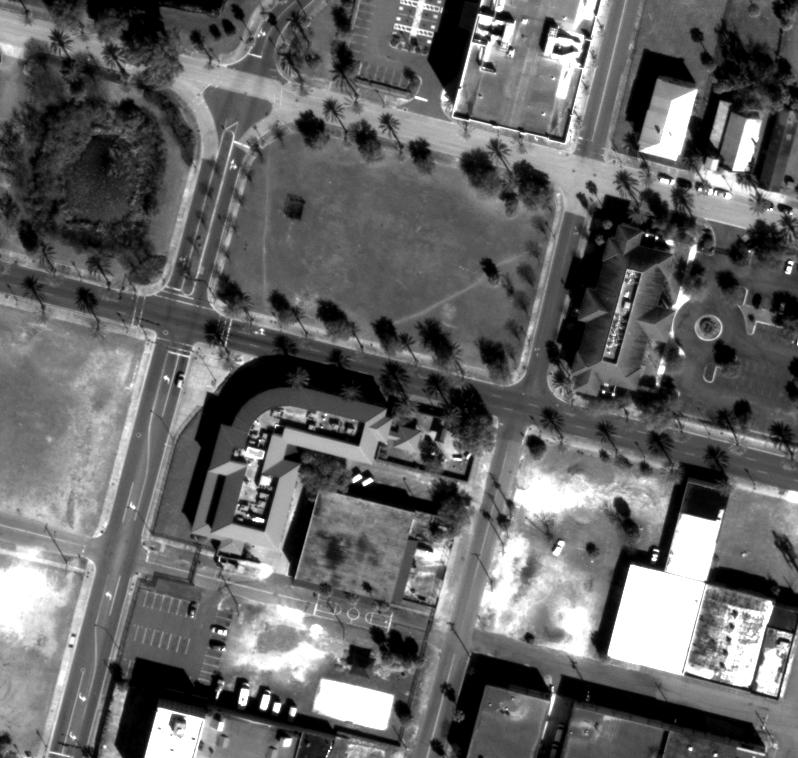
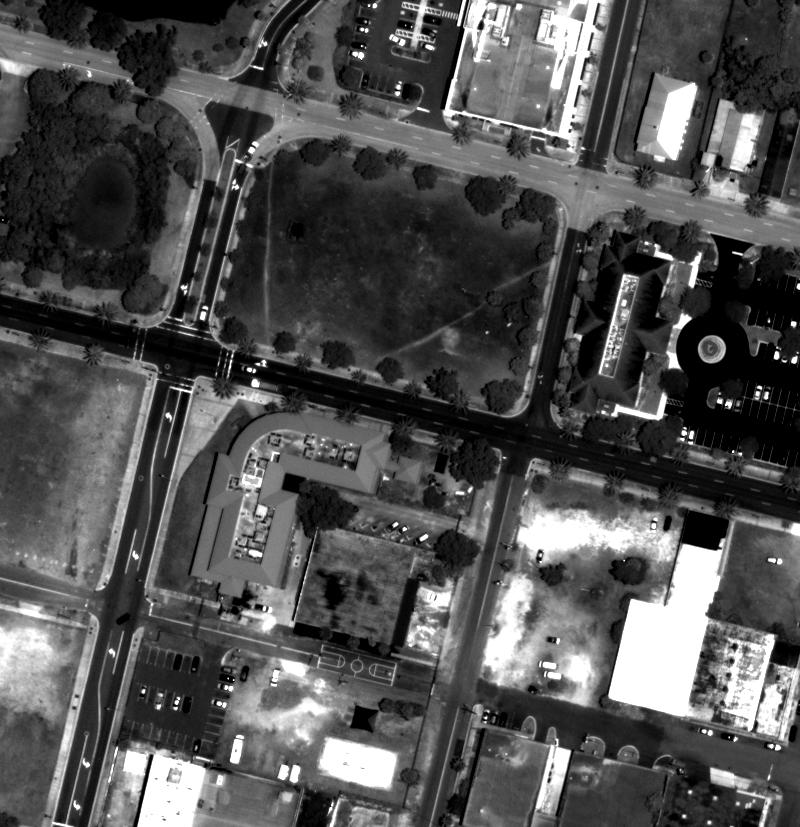
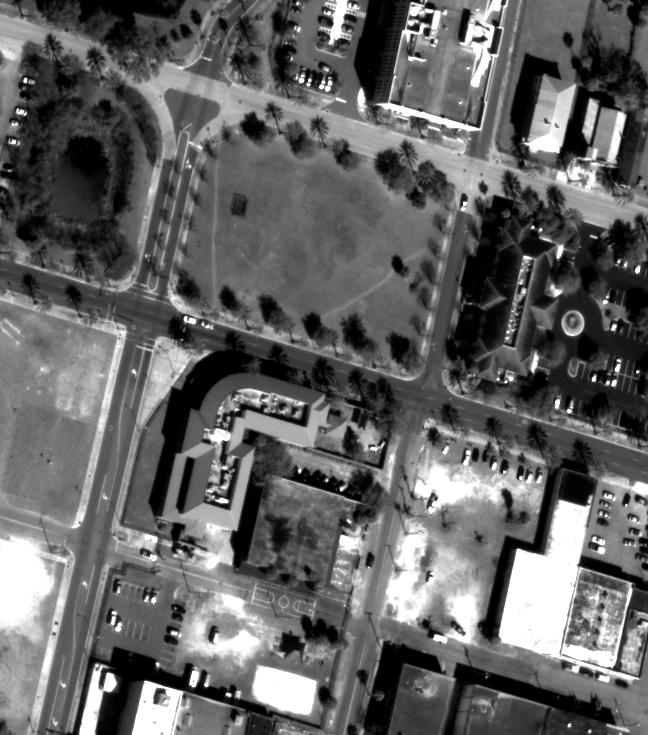
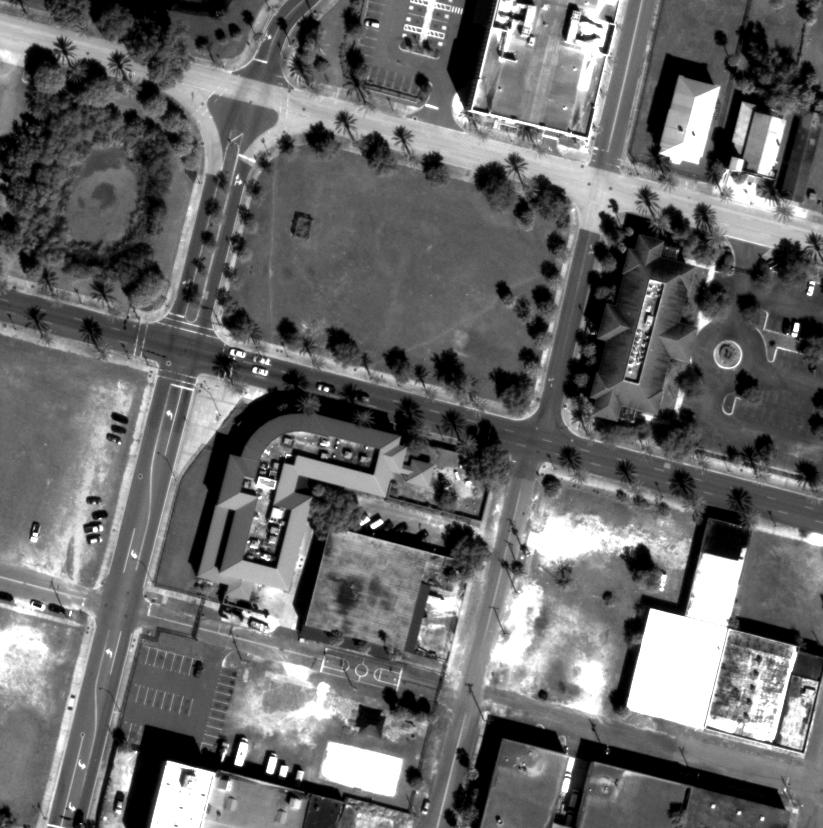
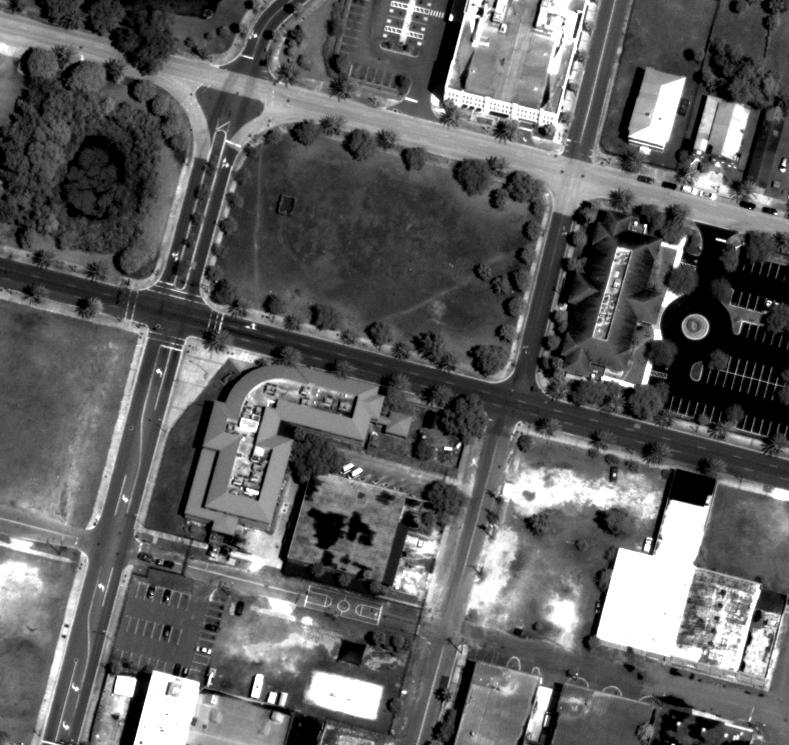
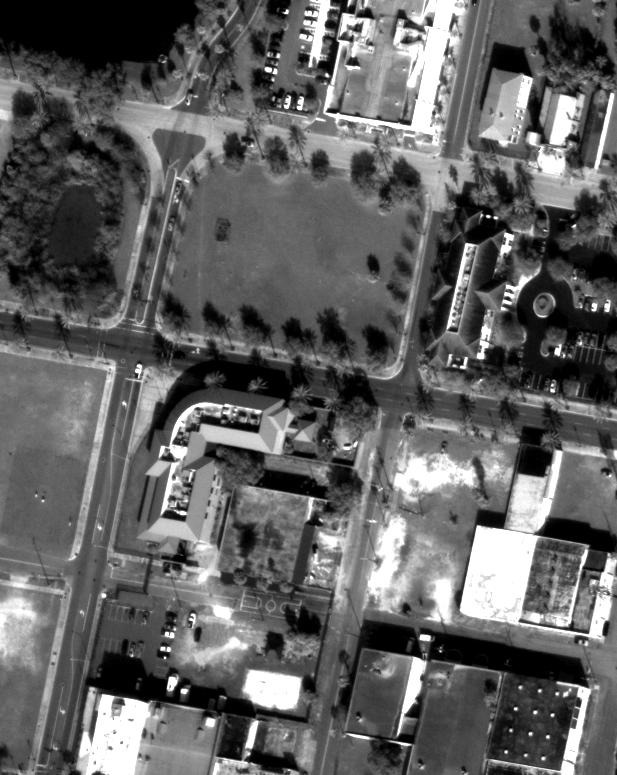
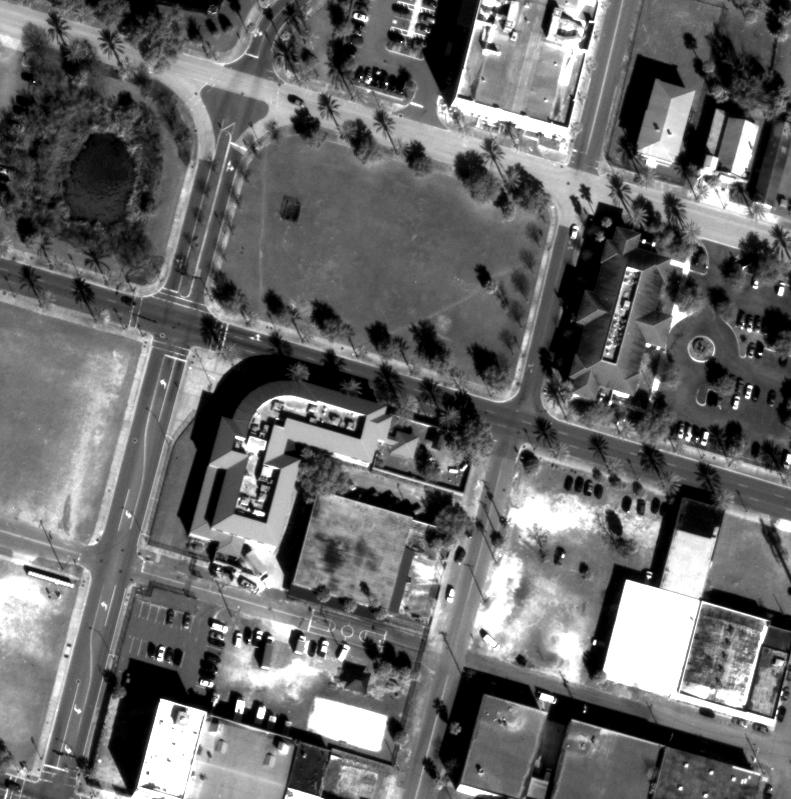
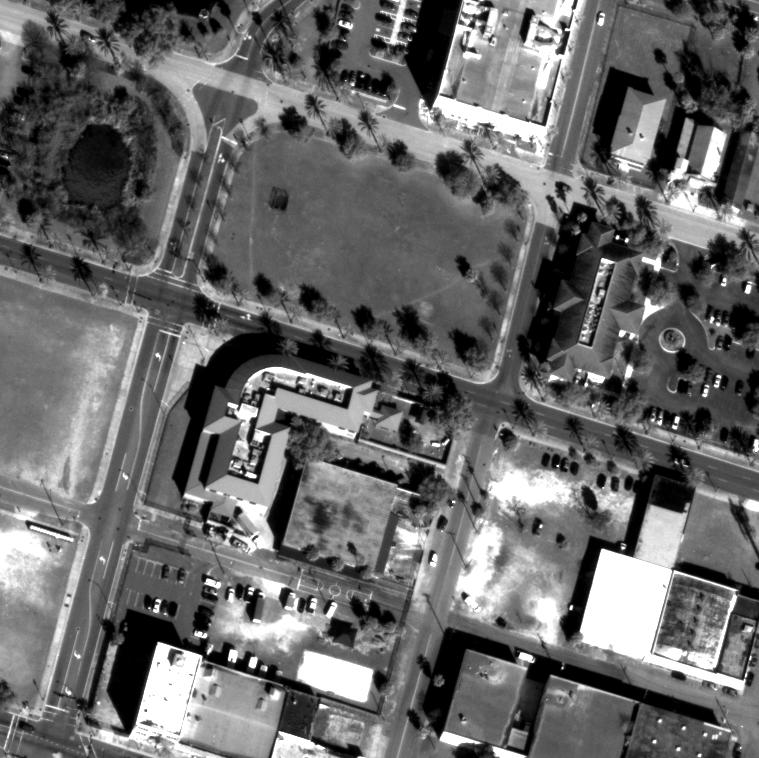
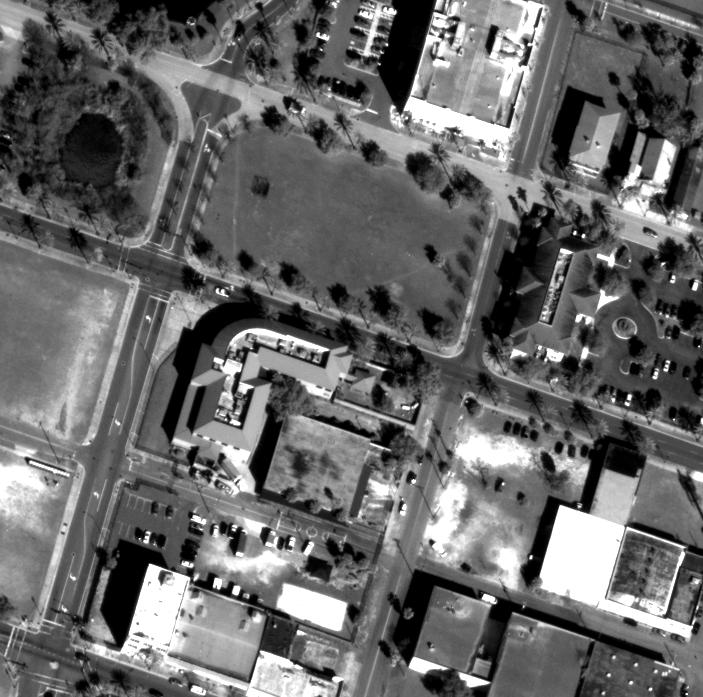
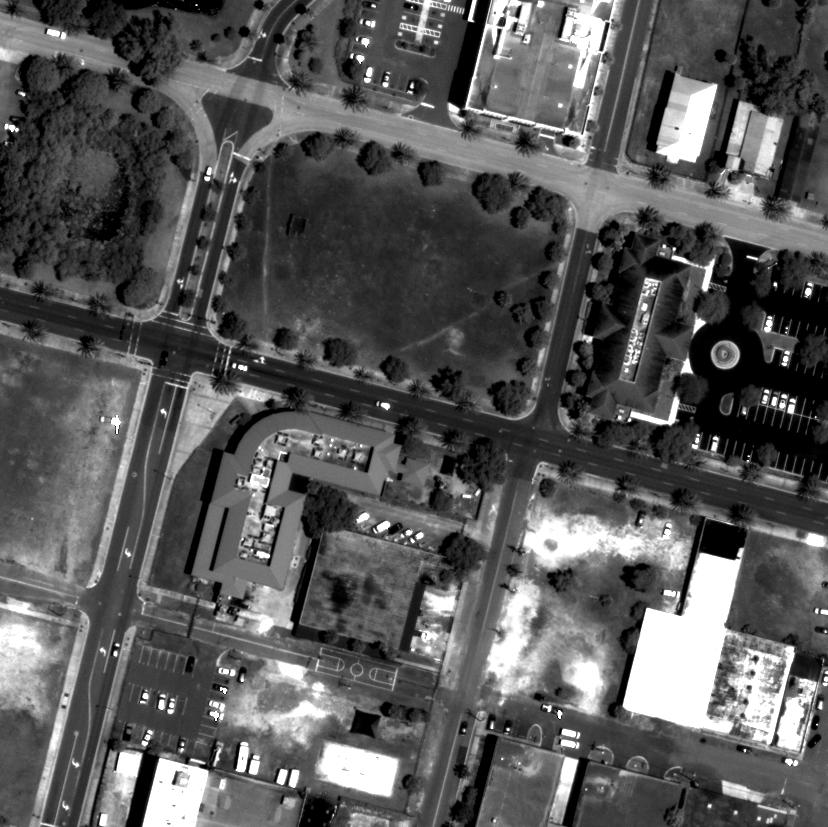
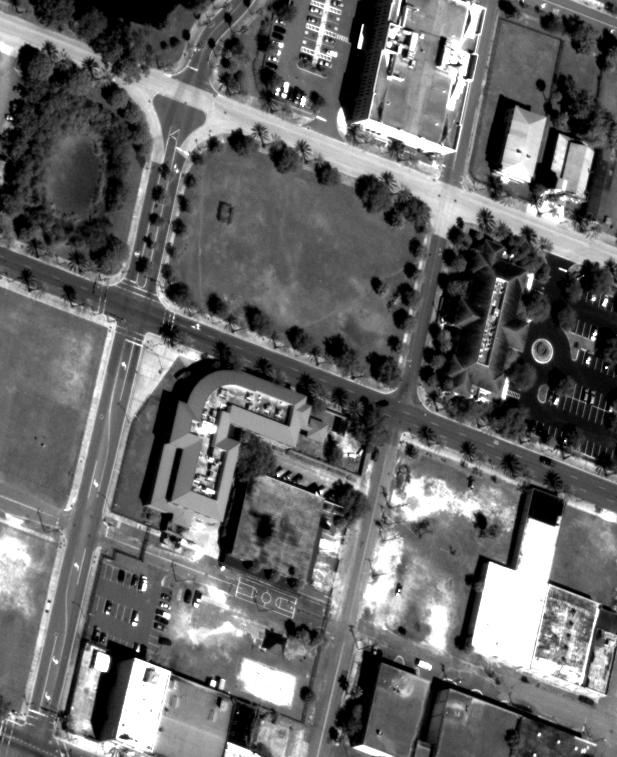
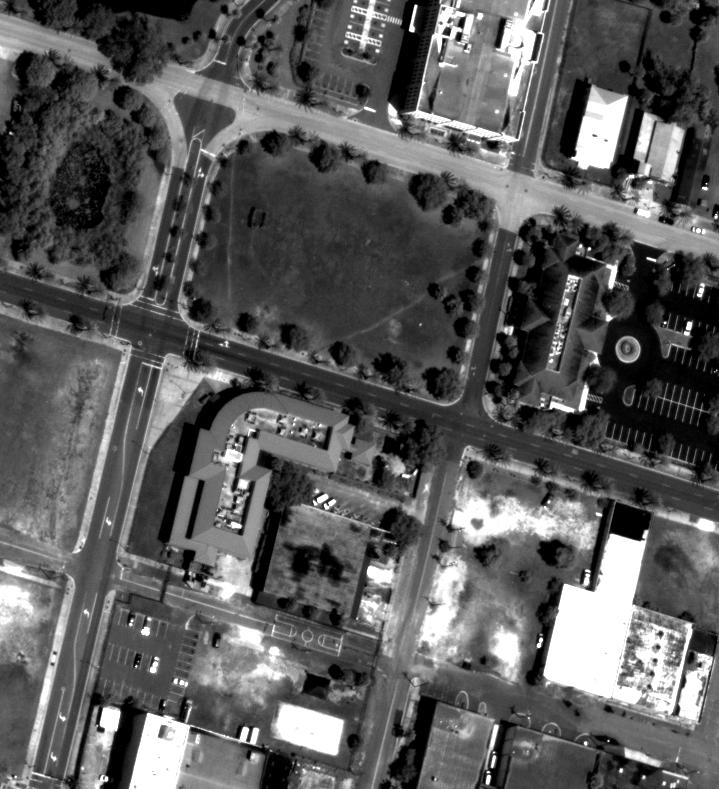
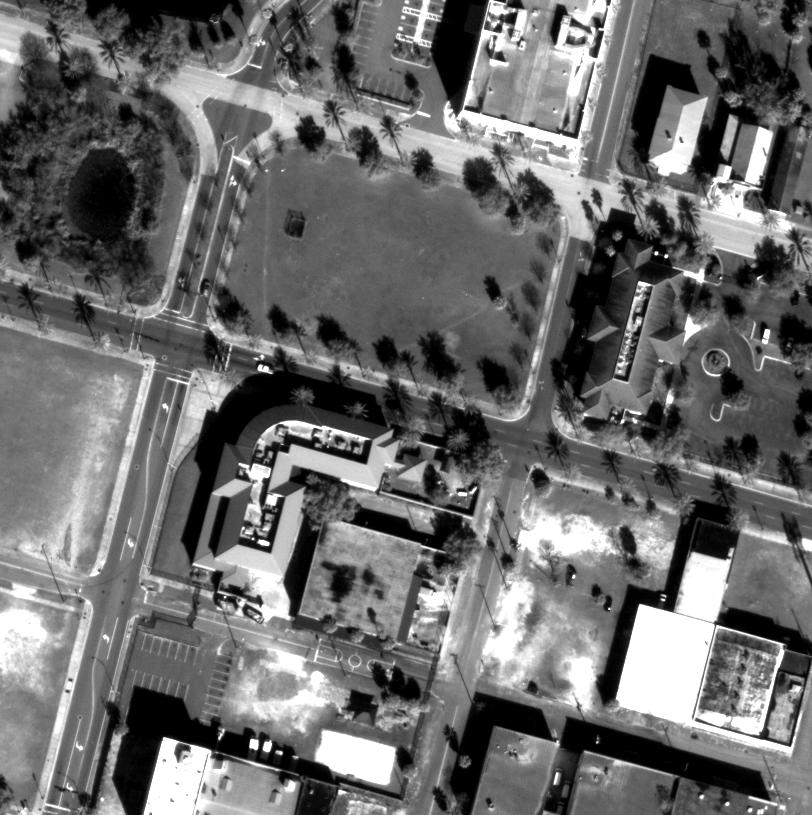
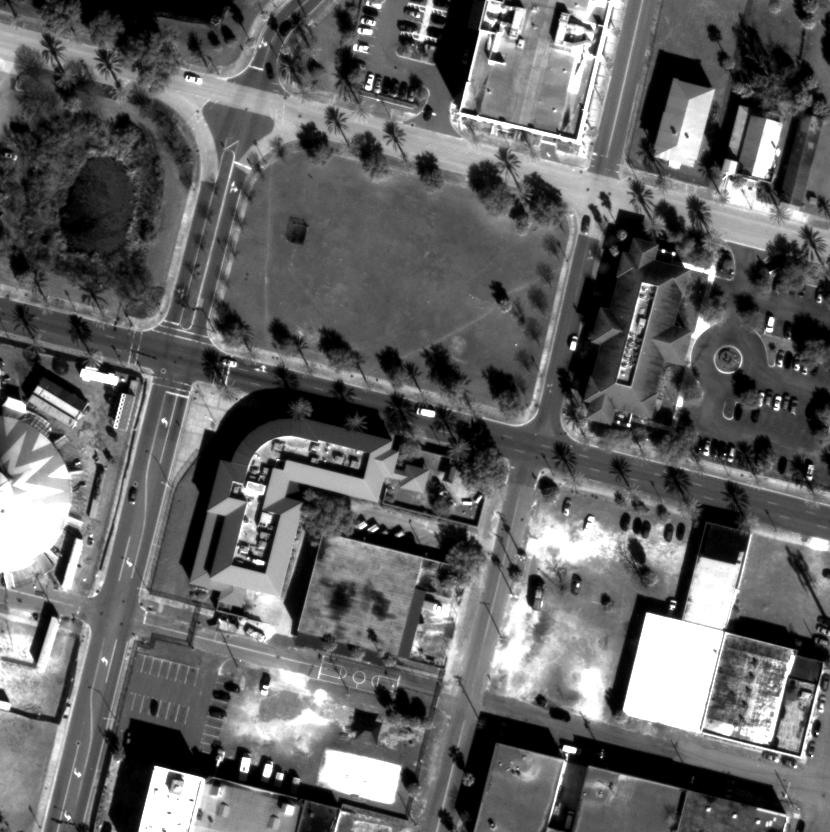
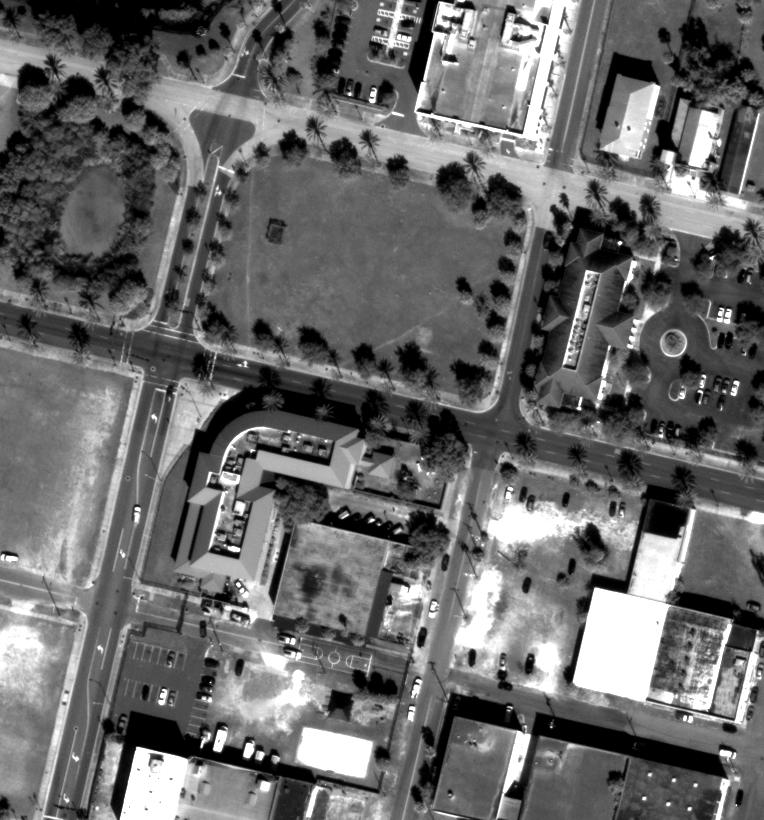

Crops were saved at data/ICCV19_JAX_161


In [4]:
if site == 'IARPA':   
    # list the tiff images available in the remote folder
    IARPAurl = 'http://138.231.80.166:2332/iarpa-2016/cloud_optimized_geotif/'
    myimages = utils.listFD(IARPAurl, 'TIF')

    # sort the images by acquisition date
    myimages = sorted(myimages, key=utils.acquisition_date)
    myimages.pop(11)
    myimages.pop(13)
    myimages.pop(19)
    print('Found {} images'.format(len(myimages)))
    
    # set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
    aoi = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                            [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field
    
elif site in ['JAX_113', 'JAX_161', 'JAX_251']:   
    # list the tiff images available in the remote folder
    myimages = utils.listFD('http://138.231.80.166:2332/core3d/Jacksonville/WV3/PAN/', '.NTF.tif')

    # list the tiff images available in the remote folder
    mygts = utils.listFD('http://138.231.80.166:2332/grss-2019/track_3/Track3-Truth-geolocated/', '_DSM.tif')
    mygt_fn = [i for i in mygts if site in i]
    aoi = utils.get_image_longlat_polygon(mygt_fn[0])
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field
    
else: 
    print('input site is not valid!')
    
# select the number of cameras for the current run
n_cam = len(myimages)
print('Number of images to be used:', n_cam)

# load RPC coefficients
myrpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# load image crops
mycrops = ba_utils.get_image_crops_from_aoi(myimages, aoi, display=True, \
                                            save_crops=True, output_dir='data/ICCV19_{}'.format(site))

### Generate feature tracks

In [8]:
#generate input feature tracks into a correspondence matrix C with shape (2*M)xN (i.e. M cameras, N tracks)

# IMPORTANT: pip3 install opencv-contrib-python==3.4.0.12

from feature_tracks.generic_pipeline import run_feature_detection_generic

n_adj, n_new = 0, len(myimages)
input_seq = [f['crop'] for f in mycrops]
feature_tracks = run_feature_detection_generic(input_dir, n_adj, n_new, myimages, input_seq,
                                               input_masks=None,
                                               use_masks=False,
                                               matching_thr=0.6,
                                               feature_detection_lib='opencv')

features = feature_tracks['features']
pairs_to_triangulate = feature_tracks['pairs_to_triangulate']
C = feature_tracks['C']
del feature_tracks

Running generic opencv feature detection...

Parameters:
      use_masks:    False
      matching_thr: 0.6


Found 5321 keypoints in image 0
Found 6468 keypoints in image 1
Found 6420 keypoints in image 2
Found 6434 keypoints in image 3
Found 5348 keypoints in image 4
Found 6346 keypoints in image 5
Found 6925 keypoints in image 6
Found 6134 keypoints in image 7
Found 6781 keypoints in image 8
Found 6271 keypoints in image 9
Found 5210 keypoints in image 10
Found 5534 keypoints in image 11
Found 6010 keypoints in image 12
Found 4713 keypoints in image 13
Found 7073 keypoints in image 14
Found 6333 keypoints in image 15
Found 5081 keypoints in image 16
Found 6740 keypoints in image 17
Found 6400 keypoints in image 18
Found 5732 keypoints in image 19
Found 6721 keypoints in image 20
Found 5305 keypoints in image 21
Found 6094 keypoints in image 22
Found 6980 keypoints in image 23
Found 7094 keypoints in image 24
Found 6889 keypoints in image 25

Detected features saved!

...done in 3.273

Pair (14,22) -> 124 matches
Pair (14,23) -> 355 matches
Pair (14,24) -> 315 matches
Pair (14,25) -> 403 matches
Pair (15,16) -> 22 matches
Pair (15,17) -> 99 matches
Pair (15,18) -> 77 matches
Pair (15,19) -> 58 matches
Pair (15,20) -> 316 matches
Pair (15,21) -> 71 matches
Pair (15,22) -> 345 matches
Pair (15,23) -> 120 matches
Pair (15,24) -> 128 matches
Pair (15,25) -> 91 matches
Pair (16,17) -> 68 matches
Pair (16,18) -> 40 matches
Pair (16,19) -> 25 matches
Pair (16,20) -> 10 matches
Pair (16,21) -> 50 matches
Pair (16,22) -> 20 matches
Pair (16,23) -> 86 matches
Pair (16,24) -> 61 matches
Pair (16,25) -> 148 matches
Pair (17,18) -> 2584 matches
Pair (17,19) -> 1251 matches
Pair (17,20) -> 82 matches
Pair (17,21) -> 57 matches
Pair (17,22) -> 94 matches
Pair (17,23) -> 1224 matches
Pair (17,24) -> 954 matches
Pair (17,25) -> 211 matches
Pair (18,19) -> 2032 matches
Pair (18,20) -> 63 matches
Pair (18,21) -> 55 matches
Pair (18,22) -> 72 matches
Pair (18,23) -> 700 matches
Pair (18

### Set BA parameters

- Warning: the method by Ozcanli et al. to initialize 3d points takes a lot of time 

In [9]:
from bundle_adjust import ba_triangulation

if site in ['JAX_113', 'JAX_161', 'JAX_251']: 
    zmin, zmax, zdelta = -30.0, 0.0, 0.5
elif site == 'IARPA':
    zmin, zmax, zdelta = 10.0, 50.0, 0.5
else: 
    print('input site is not valid!')
    
ba_cam_model = 'Affine'
    
#pts3d = ba_offsets.ba_offsets_initialize_3d_points(C, mycrops, myrpcs, zmin, zmax, zdelta)
pts3d = ba_offsets.ba_offsets_initialize_3d_points_warp(C, mycrops, myrpcs, aoi, \
                                                        pairs_to_triangulate, cam_model=ba_cam_model)

offsets, pts_ind, cam_ind, pts_2d, pts_3d, n_cam, n_pts \
= ba_offsets.ba_offsets_set_ba_params(C, pts3d, myrpcs, mycrops)

#if os.path.isfile(input_dir+'/ba_pts3d.txt'):
#    pts3d = np.loadtxt(input_dir+'/ba_pts3d.txt')
#    print('Loaded 3d pts!')
#else:
#    pts3d = np.around(pts3d, 6)
#    np.savetxt(input_dir+'/ba_pts3d.txt', pts3d, delimiter = ' ') 

Approximating RPCs as Affine projection matrices
26 projection matrices / 26 (0 err)
Done!

Initializing 14176 3d points...
...Done!

Initializing RPC correction offsets...
RPC 26 / 26
Done!

Defining the rest of BA parameters...
Done!

26 cameras in total, all will be adjusted
2 parameters per camera and 14176 3d points to be optimized


### Run Bundle Adjustment (soft L1 loss)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3174e+05                                    3.70e+03    
       1              8         3.3011e+05      1.63e+03       3.24e+02       3.67e+03    
       2              9         3.2668e+05      3.43e+03       1.38e+02       3.66e+03    
       3             10         3.2477e+05      1.91e+03       2.22e+02       3.67e+03    
       4             11         3.2155e+05      3.22e+03       1.41e+02       3.64e+03    
       5             12         3.1640e+05      5.15e+03       1.09e+01       3.61e+03    
       6             13         3.0718e+05      9.22e+03       1.13e+01       3.53e+03    
       7             14         2.9116e+05      1.60e+04       1.63e+01       3.36e+03    
       8             15         2.6381e+05      2.73e+04       2.80e+01       2.99e+03    
       9             16         2.2248e+05      4.13e+04       4.37e+01       2.57e+03    

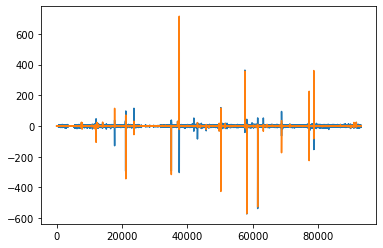

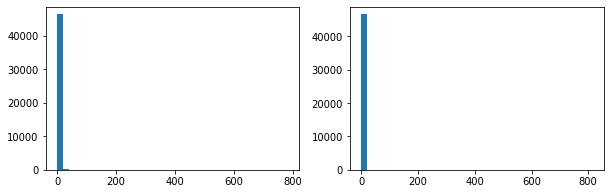

In [10]:
import time
from scipy.optimize import least_squares, minimize
from scipy.sparse import lil_matrix

# run BA
x0 = np.hstack((offsets.ravel(), pts_3d.ravel()))

# compute loss value and plot residuals at the initial parameters
f0 = ba_offsets.ba_offsets_fun(x0, cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs)
plt.plot(f0)

# define jacobian
A = ba_offsets.ba_offsets_bundle_adjustment_sparsity(cam_ind, pts_ind, n_cam, n_pts)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_offsets.ba_offsets_fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    ftol=1e-4, xtol=1e-10, method='trf', loss='soft_l1', f_scale = 5.0,
                    args=(cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba = res.x[n_cam * 2:].reshape((n_pts, 3))
offsets_ba = res.x[:n_cam * 2].reshape((n_cam, 2))


ba_e = ba_core.check_ba_error(f0, res.fun, np.ones(pts_2d.shape[0]))

### Remove outlier observations according to reprojection error

In [11]:
if os.path.isfile(input_dir+'/ba_pts3d_2.txt'):
    pickle_in = open(input_dir+'/Cmatrix2.pickle','rb')
    Cnew = pickle.load(pickle_in)
    pts3d_new = np.loadtxt(input_dir+'/ba_pts3d_2.txt')
    print('Loaded pts3d and C after outlier removal!')
else:
    # remove outlier observations according to the reprojection error after BA
    elbow_value = ba_core.get_elbow_value(ba_e, 95)
    newC = ba_core.remove_outlier_obs(ba_e, pts_ind, cam_ind, C, pairs_to_triangulate, thr=max(elbow_value,2.0))
    #pts3d_new = ba_offsets.ba_offsets_initialize_3d_points(newC, mycrops, myrpcs, zmin, zmax, zdelta)
    pts3d_new = ba_offsets.ba_offsets_initialize_3d_points_warp(newC, mycrops, myrpcs, aoi, \
                                                                pairs_to_triangulate, cam_model=ba_cam_model)
    pickle_out = open(input_dir+'/Cmatrix2.pickle','wb')
    pickle.dump(newC, pickle_out)
    pickle_out.close()
    np.savetxt(input_dir+'/ba_pts3d_2.txt', np.around(pts3d_new, 6), delimiter = ' ') 

offsets, pts_ind, cam_ind, pts_2d, pts_3d, n_cam, n_pts \
= ba_offsets.ba_offsets_set_ba_params(C, pts3d, myrpcs, mycrops)

Loaded pts3d and C after outlier removal!
Initializing RPC correction offsets...
RPC 26 / 26
Done!

Defining the rest of BA parameters...
Done!

26 cameras in total, all will be adjusted
2 parameters per camera and 14176 3d points to be optimized


### Run Bundle Adjustment (L2 loss)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6828e+06                                    5.01e+03    
       1              2         1.0876e+06      5.95e+05       1.20e+03       4.20e-01    
       2              3         1.0876e+06      6.02e-02       2.29e+00       7.83e-02    
`ftol` termination condition is satisfied.
Function evaluations 3, initial cost 1.6828e+06, final cost 1.0876e+06, first-order optimality 7.83e-02.
Optimization took 2 seconds
Error before BA (mean / median): 3.87 / 2.75
Error after  BA (mean / median): 0.83 / 0.32



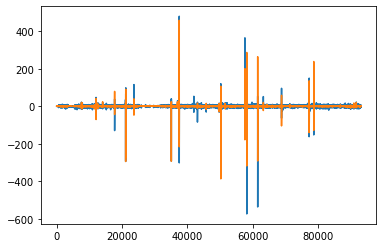

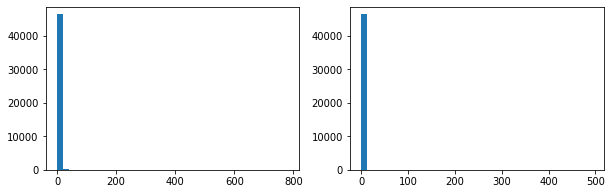

In [13]:
import time
from scipy.optimize import least_squares, minimize
from scipy.sparse import lil_matrix

# run BA
x0 = np.hstack((offsets.ravel(), pts_3d.ravel()))

# compute loss value and plot residuals at the initial parameters
f0 = ba_offsets.ba_offsets_fun(x0, cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs)
plt.plot(f0)

# define jacobian
A = ba_offsets.ba_offsets_bundle_adjustment_sparsity(cam_ind, pts_ind, n_cam, n_pts)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_offsets.ba_offsets_fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    ftol=1e-4, xtol=1e-10, method='trf', #loss='soft_l1', f_scale = 5.0,
                    args=(cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba = res.x[n_cam * 2:].reshape((n_pts, 3))
offsets_ba = res.x[:n_cam * 2].reshape((n_cam, 2))


ba_e = ba_core.check_ba_error(f0, res.fun, np.ones(pts_2d.shape[0]))

### Compute point clouds for all pairs

In [14]:
if ALL_PIPELINE:
    
    # approximate RPCs as affine cameras
    cam_model = 'Affine'
    P_crop_ba = []
    lon, lat = aoi['center'][0], aoi['center'][1]
    alt = srtm4.srtm4(lon, lat)
    p_x, p_y, p_z = ba_utils.latlon_to_ecef_custom(lat, lon, alt)
    p_geocentric = [p_x, p_y, p_z]
    for rpc, crop, j in zip(myrpcs, mycrops, np.arange(n_cam)):
        # approximate current rpc as an affine 3x4 matrix
        P_img = ba_offsets.rpc_affine_approx_with_correction_offset(rpc, p_geocentric, offsets_ba[j,:])
        x, y, w, h = utils.bounding_box_of_projected_aoi(rpc, aoi, rpc.alt_offset)
        #express P in terms of crop coord by applying the translation x0, y0 (i.e. top-left corner of the crop)
        T_crop = np.array([[1., 0., -crop['x0']], [0., 1., -crop['y0']], [0., 0., 1.]])
        current_P = T_crop @ P_img
        P_crop_ba.append(current_P/current_P[2,3])
    print('RPCs successfully approximated as affine cameras')
    
    # build point clouds
    from bundle_adjust.ba_triangulation import dense_cloud_from_pair
    
    import warnings
    warnings.filterwarnings('ignore')
    
    list_of_pairs = ba_utils.get_predefined_pairs('pairs/'+site+'_'+order+'.txt', site, order, myimages)
    os.makedirs(input_dir+'/clouds', exist_ok=True)

    print('\nComputing point clouds from stereo pairs...')
    for iter_cont, pair in enumerate(list_of_pairs):
        i, j = pair
        args = [i, j, P_crop_ba[i], P_crop_ba[j], cam_model, myimages, mycrops, aoi]
        xyz =  dense_cloud_from_pair(*args)
        ba_utils.write_point_cloud_ply(input_dir+'/clouds/dense_cloud_{:02}_{:02}.ply'.format(i,j), xyz)
        print('{} / {} done'.format(iter_cont+1, len(list_of_pairs)))
    print('\nDone!\n')

RPCs successfully approximated as affine cameras

Computing point clouds from stereo pairs...
t=4.1248 done building CV
t=8.7496 done sgmfilter
t=9.5120 done aggregation and WTA refinement
t=3.7722 done building CV
t=7.6812 done sgmfilter
t=7.9416 done aggregation and WTA refinement
1 / 50 done
t=3.8954 done building CV
t=8.1774 done sgmfilter
t=8.4523 done aggregation and WTA refinement
t=3.9131 done building CV
t=8.1068 done sgmfilter
t=8.3807 done aggregation and WTA refinement
2 / 50 done
t=2.9924 done building CV
t=6.5716 done sgmfilter
t=6.7965 done aggregation and WTA refinement
t=3.0767 done building CV
t=6.9949 done sgmfilter
t=7.2186 done aggregation and WTA refinement
3 / 50 done
t=3.8046 done building CV
t=7.7374 done sgmfilter
t=7.9920 done aggregation and WTA refinement
t=4.0404 done building CV
t=8.1793 done sgmfilter
t=8.4340 done aggregation and WTA refinement
4 / 50 done
t=4.4051 done building CV
t=9.2703 done sgmfilter
t=9.5659 done aggregation and WTA refinement
t=4

t=4.1530 done building CV
t=8.6206 done sgmfilter
t=8.8870 done aggregation and WTA refinement
40 / 50 done
t=3.3430 done building CV
t=7.2077 done sgmfilter
t=7.4535 done aggregation and WTA refinement
t=3.2102 done building CV
t=7.0187 done sgmfilter
t=7.2385 done aggregation and WTA refinement
41 / 50 done
t=2.7413 done building CV
t=6.2107 done sgmfilter
t=6.4009 done aggregation and WTA refinement
t=2.6379 done building CV
t=6.2584 done sgmfilter
t=6.4558 done aggregation and WTA refinement
42 / 50 done
t=5.4895 done building CV
t=10.8128 done sgmfilter
t=11.1895 done aggregation and WTA refinement
t=6.0413 done building CV
t=11.9399 done sgmfilter
t=12.3155 done aggregation and WTA refinement
43 / 50 done
t=4.4189 done building CV
t=8.9598 done sgmfilter
t=9.2389 done aggregation and WTA refinement
t=4.2761 done building CV
t=8.9801 done sgmfilter
t=9.2603 done aggregation and WTA refinement
44 / 50 done
t=5.7790 done building CV
t=11.2727 done sgmfilter
t=11.6298 done aggregatio